Compute correction for dust extinction due to the extinction within the galaxy (should be a function of inclination).

In [1]:
import numpy as np

from astropy.table import Table, join
from astropy.io import fits
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18
import astropy.constants as const
import astropy.units as u

from hyperfit.linfit import LinFit

from scipy.optimize import minimize

import time

import corner

import pickle

import matplotlib.pyplot as plt
#UNCOMMENT FOR 3D PLOTS
# %matplotlib widget

import sys
sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
# sys.path.insert(1, '/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/')
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust

In [2]:
c = const.c.to('km/s')

q0 = 0.2

# Data

## Galaxies

In [3]:
gals_directory = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/'
# gals_directory = ''

gals_filename = 'SGA-2020_iron_Vrot_VI_photsys.fits'

gals = Table.read(gals_directory + gals_filename)

In [4]:
gals[:5]

<Table length=5>
SGA_ID  SGA_GALAXY           GALAXY         ...    V_0p4R26_err    PHOTSYS
int64    bytes16            bytes29         ...      float64        bytes1
------ ------------ ----------------------- ... ------------------ -------
    38  SGA-2020 38 SDSSJ140638.88+393138.1 ... 2.5088414493427758       N
    55  SGA-2020 55              PGC1203947 ... 3.1180004761210594       S
   117 SGA-2020 117  2MASXJ09154446+0241407 ...  8.453666000234023       S
   223 SGA-2020 223 SDSSJ131108.84+341016.9 ...   4.27530627605531       N
   581 SGA-2020 581              PGC1576398 ... 4.4513439166676285       S

# Empirical internal dust extinction correction

Can we find (and correct for) any correlation between the axis ratio and the color of the galaxies?

## Calculate the "known" photometric corrections

### Survey offsets

In [5]:
sys_corr, sys_corr_err = BASS_corr(gals['PHOTSYS'])

### Dust corrections

In [6]:
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
# ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [7]:
dust_corr, dust_corr_err = MW_dust(gals['RA'], gals['DEC'], ebv_map)

/global/u1/k/kadglass/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [8]:
# Flip NaN values to 0
dust_corr_err[np.isnan(dust_corr_err)] = 0

### $K$-corrections

In [9]:
zg0 = gals['Z_DESI'] >= 0

In [10]:
kcorr_zg0 = k_corr(gals['Z_DESI'][zg0], 
                   [gals['G_MAG_SB26'][zg0], gals['R_MAG_SB26'][zg0], gals['Z_MAG_SB26'][zg0]], 
                   [gals['G_MAG_SB26_ERR'][zg0], gals['R_MAG_SB26_ERR'][zg0], gals['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1)

In [11]:
kcorr = np.zeros((len(gals), 3))
kcorr[zg0] = kcorr_zg0

## Apply "known" corrections

In [12]:
gals['G_MAG_SB26_CORR'] = gals['G_MAG_SB26'] - dust_corr[0] + sys_corr + kcorr[:,0]
gals['R_MAG_SB26_CORR'] = gals['R_MAG_SB26'] - dust_corr[1] + sys_corr + kcorr[:,1]
gals['Z_MAG_SB26_CORR'] = gals['Z_MAG_SB26'] - dust_corr[2] + sys_corr + kcorr[:,2]

In [13]:
gals['G_MAG_SB26_ERR_CORR'] = np.sqrt(gals['G_MAG_SB26_ERR']**2 + dust_corr_err[0]**2 + sys_corr_err**2)
gals['R_MAG_SB26_ERR_CORR'] = np.sqrt(gals['R_MAG_SB26_ERR']**2 + dust_corr_err[1]**2 + sys_corr_err**2)
gals['Z_MAG_SB26_ERR_CORR'] = np.sqrt(gals['Z_MAG_SB26_ERR']**2 + dust_corr_err[2]**2 + sys_corr_err**2)

## Convert $R_{26}$ to kpc

In [14]:
dist = Distance(z=np.abs(gals['Z_DESI']), cosmology=Planck18)

In [15]:
rng = np.random.default_rng()

N_samples = 1000

dist_err = np.empty(len(dist))*u.Mpc

for i in range(len(dist_err)):
    
    z_desi_random = rng.normal(np.abs(gals['Z_DESI'][i]), 
                               gals['ZERR_DESI'][i], 
                               N_samples)
    
    d_random = Distance(z=z_desi_random, cosmology=Planck18)
    
    dist_err[i] = np.std(d_random)

In [16]:
gals['R26_kpc'] = dist.to('kpc')*np.tan(0.5*gals['D26']*u.arcmin)
gals['R26_kpc_err'] = dist_err.to('kpc')*np.tan(0.5*gals['D26']*u.arcmin)

## Correlation between color and axis ratio?

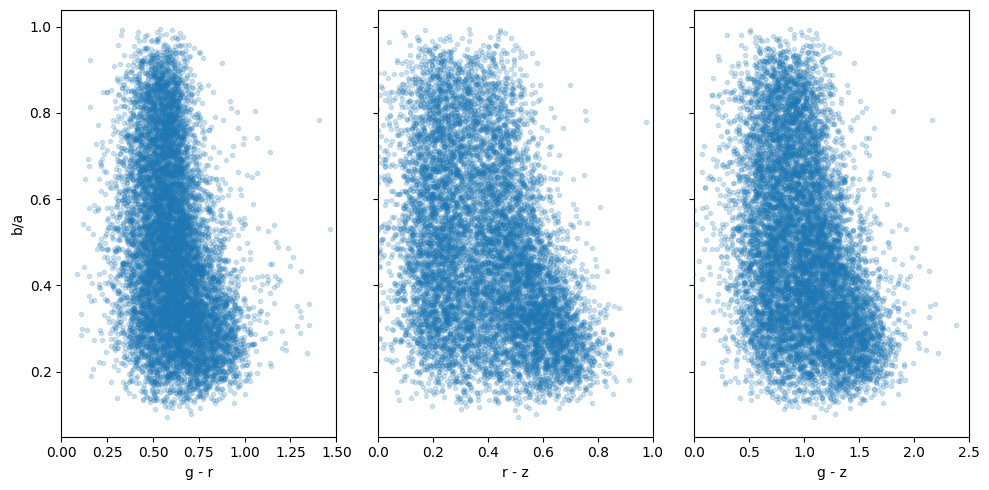

In [18]:
fig, ax = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(10,5))

ax[0].plot(gals['G_MAG_SB26_CORR'] - gals['R_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[0].set_xlabel('g - r')
ax[0].set_ylabel('b/a')
ax[0].set_xlim([0, 1.5])

ax[1].plot(gals['R_MAG_SB26_CORR'] - gals['Z_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[1].set_xlabel('r - z')
ax[1].set_xlim([0, 1])

ax[2].plot(gals['G_MAG_SB26_CORR'] - gals['Z_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[2].set_xlabel('g - z')
ax[2].set_xlim([0, 2.5]);

## Correlation between magnitude and axis ratio?

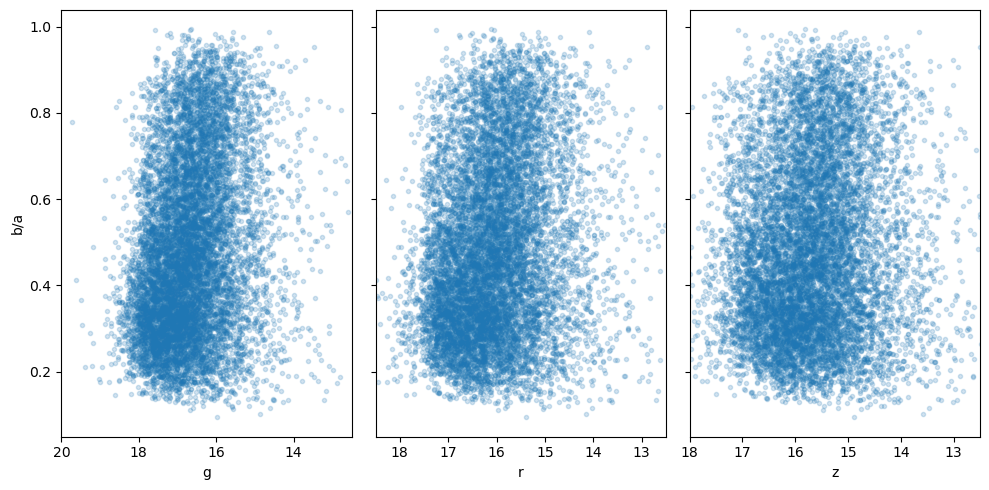

In [18]:
fig, ax = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(10,5))

ax[0].plot(gals['G_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[0].set_xlabel('g')
ax[0].set_ylabel('b/a')
ax[0].set_xlim([20, 12.5])

ax[1].plot(gals['R_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[1].set_xlabel('r')
ax[1].set_xlim([18.5, 12.5])

ax[2].plot(gals['Z_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[2].set_xlabel('z')
ax[2].set_xlim([18, 12.5]);

## Correlation between magnitude, $R_{26}$, and axis ratio?

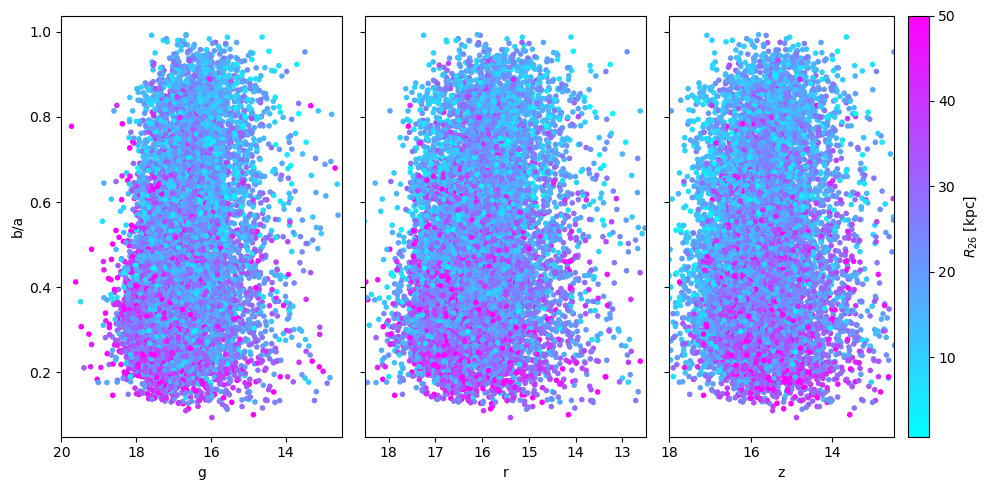

In [19]:
fig, ax = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(10,5))

ax[0].scatter(gals['G_MAG_SB26_CORR'], gals['BA'], c=gals['R26_kpc'], marker='.', vmax=50, cmap='cool')
ax[0].set_xlabel('g')
ax[0].set_ylabel('b/a')
ax[0].set_xlim([20, 12.5])

ax[1].scatter(gals['R_MAG_SB26_CORR'], gals['BA'], c=gals['R26_kpc'], marker='.', vmax=50, cmap='cool')
ax[1].set_xlabel('r')
ax[1].set_xlim([18.5, 12.5])

zplot = ax[2].scatter(gals['Z_MAG_SB26_CORR'], gals['BA'], c=gals['R26_kpc'], marker='.', vmax=50, cmap='cool')
ax[2].set_xlabel('z')
ax[2].set_xlim([18, 12.5])

plt.colorbar(zplot, label='$R_{26}$ [kpc]');

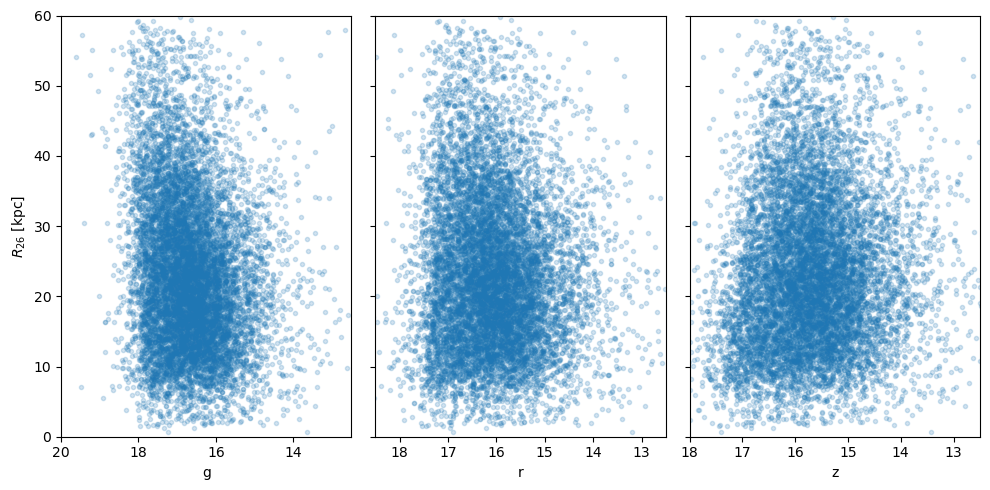

In [20]:
fig, ax = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(10,5))

ax[0].plot(gals['G_MAG_SB26_CORR'], gals['R26_kpc'], '.', alpha=0.2)
ax[0].set_xlabel('g')
ax[0].set_ylabel('$R_{26}$ [kpc]')
ax[0].set_xlim([20, 12.5])
ax[0].set_ylim([0, 60])

ax[1].plot(gals['R_MAG_SB26_CORR'], gals['R26_kpc'], '.', alpha=0.2)
ax[1].set_xlabel('r')
ax[1].set_xlim([18.5, 12.5])

ax[2].plot(gals['Z_MAG_SB26_CORR'], gals['R26_kpc'], '.', alpha=0.2)
ax[2].set_xlabel('z')
ax[2].set_xlim([18, 12.5]);

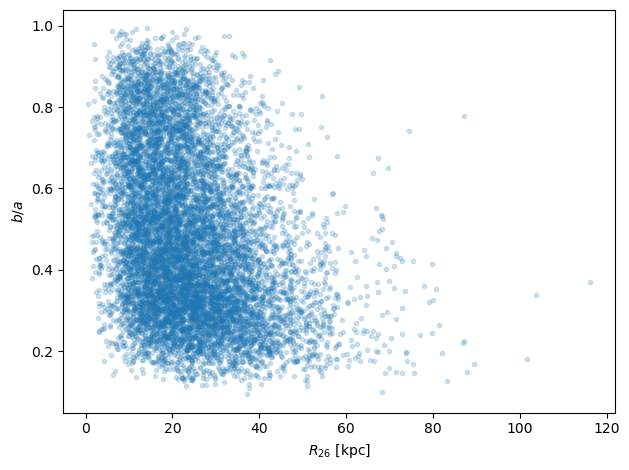

In [21]:
plt.figure(tight_layout=True)

plt.plot(gals['R26_kpc'], gals['BA'], '.', alpha=0.2)

plt.xlabel('$R_{26}$ [kpc]')
plt.ylabel('$b/a$');

## Let's try fitting a plane to ($m_r$, $b/a$, $R_{26}$)

We're going to let $x = b/a$, $y = R_{26}$, and $z = m_r$

### Calculate median $m_r$ in bins of ($b/a$, $R_{26}$)

In [43]:
ba = np.arange(0,1,0.1)
R26 = np.arange(0,80,5)
ba_grid, R26_grid = np.meshgrid(ba, R26)

mr_grid = np.nan*np.ones(ba_grid.shape)

for i in range(ba_grid.shape[1]):
    
    gals_subset_ba = gals[(gals['BA'] > i*0.1) & (gals['BA'] <= (i+1)*0.1)]
    
    for j in range(ba_grid.shape[0]):
        
        gals_R26_subset = gals_subset_ba[(gals_subset_ba['R26_kpc'] > j*5) & (gals_subset_ba['R26_kpc'] <= (j+1)*5)]
        
        mr_grid[j,i] = np.median(gals_R26_subset['R_MAG_SB26_CORR'])

/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [44]:
# Do something to compute uncertainties in each of these bins

In [45]:
N = len(gals['R_MAG_SB26_CORR'])
N_grid = mr_grid.shape[0]*mr_grid.shape[1]

In [46]:
# Create covariance matrix, assuming each parameter is independent of the others
cov = np.empty((3, 3, N))

for i in range(N):
    cov[:,:,i] = np.array([[0.001**2, 0., 0.], [0., gals['R26_kpc_err'][i]**2, 0.], [0., 0., gals['R_MAG_SB26_ERR_CORR'][i]**2]])
    

cov_grid = np.empty((3, 3, N_grid))

for i in range(N_grid):
    cov_grid[:,:,i] = np.array([[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]])

In [47]:
# Shift the pivot point (y-intercept) to minimize the correlations between the fit coefficients
mr_median = np.median(gals['R_MAG_SB26_CORR'])
print(mr_median)

16.1215309809694


In [48]:
# Create the Hyperfit object
# hf = LinFit([gals['BA'], gals['R26_kpc'], gals['R_MAG_SB26_CORR'] - mr_median], cov)
hf_grid = LinFit([np.ravel(ba_grid), np.ravel(R26_grid), np.ravel(mr_grid) - mr_median], cov_grid)

In [49]:
# Set bounds of coefficients
bounds = ((-100.0, 0.0), (-10.0, 10.0), (-100.0, 100.0), (1.0e-5, 50.))

In [50]:
# Run MCMC to fit plane
# mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)
mcmc_samples, mcmc_lnlike = hf_grid.emcee(bounds, verbose=True)

     fun: nan
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 60165
     nit: 1000
 success: False
       x: array([10.4723774 , 12.48463479, 94.05871829, 17.2593827 ])


ValueError: Probability function returned NaN

In [46]:
# Calculate parameter values and covariance matrix
A_ba, B_R26, C, sig = np.median(mcmc_samples, axis=1)

cov_fit = np.cov(mcmc_samples)

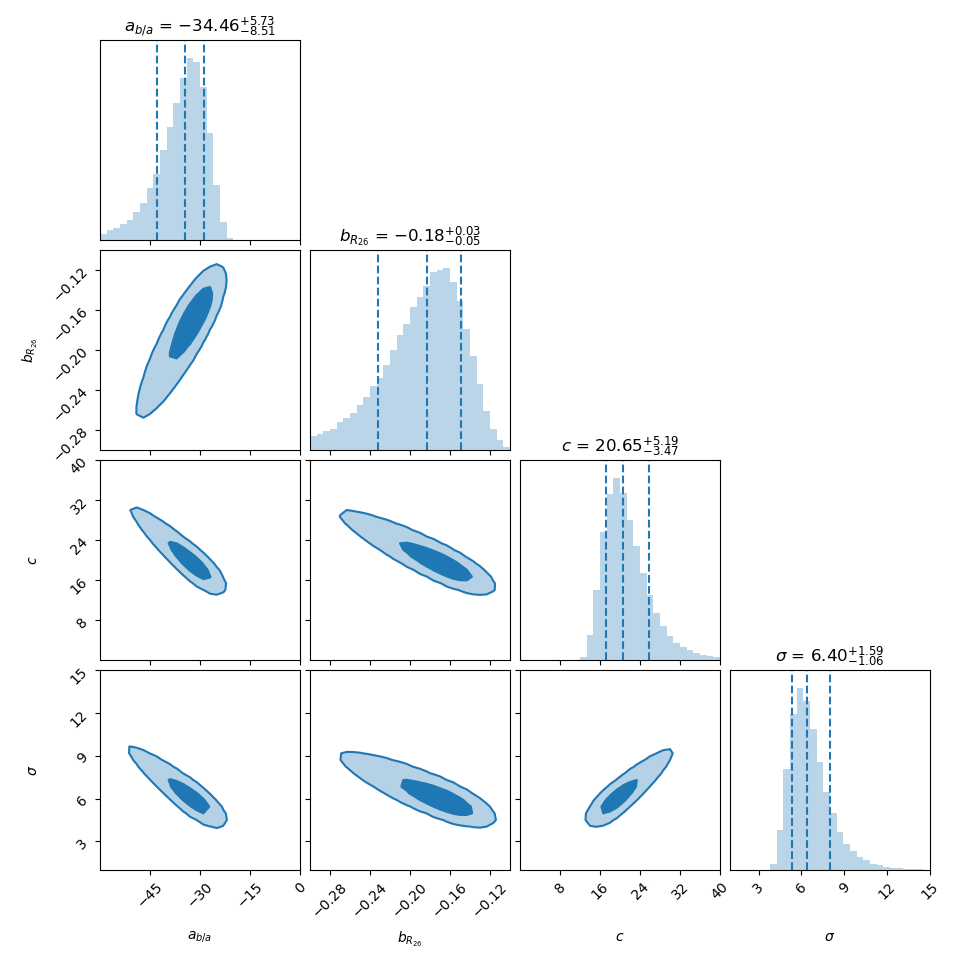

In [47]:
fig = corner.corner(mcmc_samples.T, 
                    bins=30, 
                    smooth=1, 
                    range=[[-60, 0], [-0.3, -0.1], [0, 40], [1, 15]],
                    labels=['$a_{b/a}$', '$b_{R_{26}}$', '$c$', r'$\sigma$'], 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)), 
                    quantiles=[0.16, 0.5, 0.84], 
                    color='tab:blue', 
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3}, 
                    plot_datapoints=False,
                    fill_contours=True, 
                    show_titles=True);

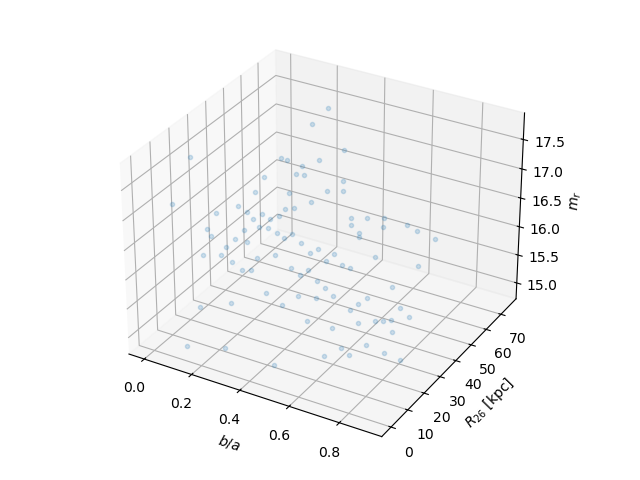

In [35]:
fig = plt.figure(tight_layout=True)
ax = fig.add_subplot(projection='3d')

# ax.plot(gals['BA'], gals['R26_kpc'], gals['R_MAG_SB26_CORR'], '.', alpha=0.2)
ax.plot(np.ravel(ba_grid), np.ravel(R26_grid), np.ravel(mr_grid), '.', alpha=0.2)

# ax.plot_wireframe(ba_grid, R26_grid, A_ba*ba_grid + B_R26*R26_grid + (C + mr_median), colors='k')

ax.set_xlabel('$b/a$')
ax.set_ylabel('$R_{26}$ [kpc]')
ax.set_zlabel('$m_r$');

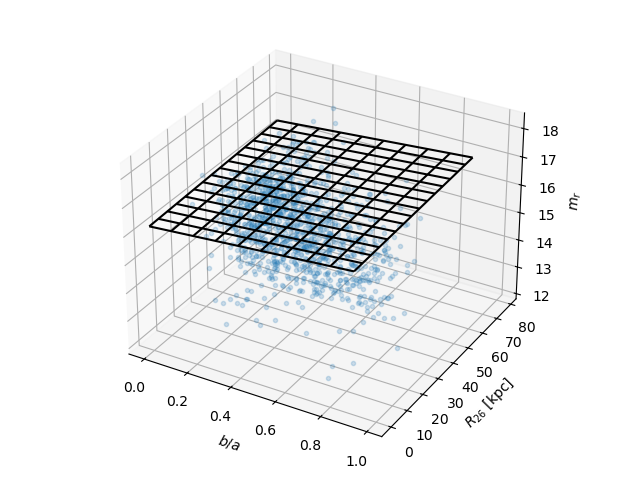

In [49]:
# Results from minimize: [0.59896149, 0.00317231, 0.01740659, 0.18515053]
fig = plt.figure(tight_layout=True)
ax = fig.add_subplot(projection='3d')

ax.plot(gals['BA'], gals['R26_kpc'], gals['R_MAG_SB26_CORR'], '.', alpha=0.2)

ax.plot_wireframe(ba_grid, R26_grid, 0.59896149*ba_grid + 0.00317231*R26_grid + (0.01740659 + mr_median), colors='k')

ax.set_xlabel('$b/a$')
ax.set_ylabel('$R_{26}$ [kpc]')
ax.set_zlabel('$m_r$');

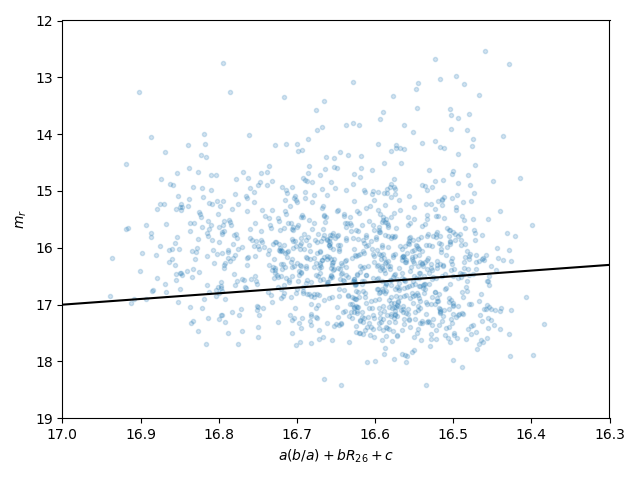

In [53]:
plt.figure(tight_layout=True)

plt.plot(0.59896149*gals['BA'] + 0.00317231*gals['R26_kpc'] + (0.01740659 + mr_median), 
         gals['R_MAG_SB26_CORR'], 
         '.', 
         alpha=0.2)

plt.plot([12, 18], [12, 18], 'k')

plt.xlim([17, 16.3])
plt.ylim([19, 12])

plt.xlabel('$a(b/a) + bR_{26} + c$')
plt.ylabel('$m_r$');

## Let's try fitting a plane to ($m_r$, color, and $b/a$)

We're going to let $x = b/a$, $y = r-z$ (because $r-z$ has the strongest correlation with $b/a$), and $z = m_r$

### Calculate median $m_r$ in bins of ($b/a$, $r-z$)

In [94]:
ba = np.arange(0,1,0.1)
rz = np.arange(0,1,0.1)
ba_grid, rz_grid = np.meshgrid(ba, rz)

mr_grid = np.nan*np.ones(ba_grid.shape)

N_grid = mr_grid.shape[0]*mr_grid.shape[1]
cov_grid = np.empty((3, 3, N_grid))

for i in range(ba_grid.shape[1]):
    
    gals_subset_ba = gals[(gals['BA'] > i*0.1) & (gals['BA'] <= (i+1)*0.1)]
    
    for j in range(ba_grid.shape[0]):
        
        gals_rz_subset = gals_subset_ba[((gals_subset_ba['R_MAG_SB26_CORR'] - gals_subset_ba['Z_MAG_SB26_CORR']) > j*0.1) & ((gals_subset_ba['R_MAG_SB26_CORR'] - gals_subset_ba['Z_MAG_SB26_CORR']) <= (j+1)*0.1)]
        
        mr_grid[j,i] = np.median(gals_rz_subset['R_MAG_SB26_CORR'])

        cov_grid[:,:,i*j + j] = len(gals_rz_subset)*np.identity(3)

In [95]:
# Create covariance matrix, assuming each parameter is independent of the others
N = len(gals['R_MAG_SB26_CORR'])

cov = np.empty((3, 3, N))

for i in range(N):
    cov[:,:,i] = np.array([[0.01**2, 0., 0.], 
                           [0., (gals['R_MAG_SB26_ERR_CORR'][i]**2 + gals['Z_MAG_SB26_ERR_CORR'][i]**2), gals['R_MAG_SB26_ERR_CORR'][i]**2], 
                           [0., gals['R_MAG_SB26_ERR_CORR'][i]**2, gals['R_MAG_SB26_ERR_CORR'][i]**2]])

In [96]:
cov

array([[[0.0001    , 0.0001    , 0.0001    , ..., 0.0001    ,
         0.0001    , 0.0001    ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.00346815, 0.00087708, 0.00242973, ..., 0.00245786,
         0.00142091, 0.00302402],
        [0.00164821, 0.00047681, 0.00126047, ..., 0.00138709,
         0.00077383, 0.00156452]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.00164821, 0.00047681, 0.00126047, ..., 0.00138709,
         0.00077383, 0.00156452],
        [0.00164821, 0.00047681, 0.00126047, ..., 0.00138709,
         0.00077383, 0.00156452]]])

In [97]:
# Shift the pivot point (y-intercept) to minimize the correlations between the fit coefficients
mr_median = np.median(gals['R_MAG_SB26_CORR'])
print(mr_median)

16.1215309809694


In [98]:
# Create the Hyperfit object
hf = LinFit([gals['BA'], gals['R_MAG_SB26_CORR'] - gals['Z_MAG_SB26_CORR'], gals['R_MAG_SB26_CORR'] - mr_median], cov)
# hf_grid = LinFit([np.ravel(ba_grid), np.ravel(rz_grid), np.ravel(mr_grid) - mr_median], cov_grid)

In [99]:
# Set bounds of coefficients
bounds = ((-100.0, 1.0), (-10.0, 10.0), (-1.0, 10.0), (1.0e-5, 50.))

In [100]:
# Run MCMC to fit plane
mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)
# mcmc_samples, mcmc_lnlike = hf_grid.emcee(bounds, verbose=True)

     fun: -13441.354681248762
     jac: array([ 1.98124326, -0.61627361,  0.53860276,  0.24756446])
 message: 'Optimization terminated successfully.'
    nfev: 3750
     nit: 61
 success: True
       x: array([0.44397033, 0.41396538, 0.02067235, 0.15817746])


100%|██████████| 1000/1000 [00:03<00:00, 279.79it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [33.35149673 35.38359901 32.42254013 36.14738948] / 1807.3694740502428


100%|██████████| 1000/1000 [00:03<00:00, 279.62it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [36.59626426 38.56042003 35.89697782 42.28886141] / 2114.4430706283524


100%|██████████| 1000/1000 [00:03<00:00, 273.58it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [48.3914379  50.51668917 37.51673769 45.72566318] / 2525.8344586357734


100%|██████████| 1000/1000 [00:03<00:00, 280.10it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.08731963 45.68009675 39.15012003 43.78649216] / 2284.00483764676


100%|██████████| 1000/1000 [00:03<00:00, 276.29it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.16363464 45.47065674 41.57510153 48.16245251] / 2408.122625695631


100%|██████████| 1000/1000 [00:03<00:00, 272.15it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.07775592 46.343856   44.35818898 43.60449295] / 2317.1927999699387


100%|██████████| 1000/1000 [00:03<00:00, 281.47it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.70643359 43.51473621 46.63585909 42.72464507] / 2331.7929544160093


100%|██████████| 1000/1000 [00:03<00:00, 280.01it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.81065498 42.18484509 50.14351953 44.96157952] / 2507.1759766844784


100%|██████████| 1000/1000 [00:03<00:00, 277.12it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [48.59011192 45.54752391 51.96115415 44.84783781] / 2598.057707708204


100%|██████████| 1000/1000 [00:03<00:00, 271.48it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.78413691 44.30580912 49.32348489 43.6623232 ] / 2466.1742444337333


100%|██████████| 1000/1000 [00:03<00:00, 269.49it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.49543749 45.37409024 51.60713998 46.24738578] / 2580.3569988128957


100%|██████████| 1000/1000 [00:03<00:00, 278.49it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.83260424 44.70829792 52.85833311 48.85705604] / 2642.9166557109875


100%|██████████| 1000/1000 [00:03<00:00, 281.62it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [46.90030471 47.18886686 55.1624189  47.88436398] / 2758.120945048495


100%|██████████| 1000/1000 [00:03<00:00, 277.82it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [48.86268181 46.32047995 53.08191428 48.38047288] / 2654.095714187556


In [101]:
# Calculate parameter values and covariance matrix
A_ba, B_rz, C, sig = np.median(mcmc_samples, axis=1)

cov_fit = np.cov(mcmc_samples)

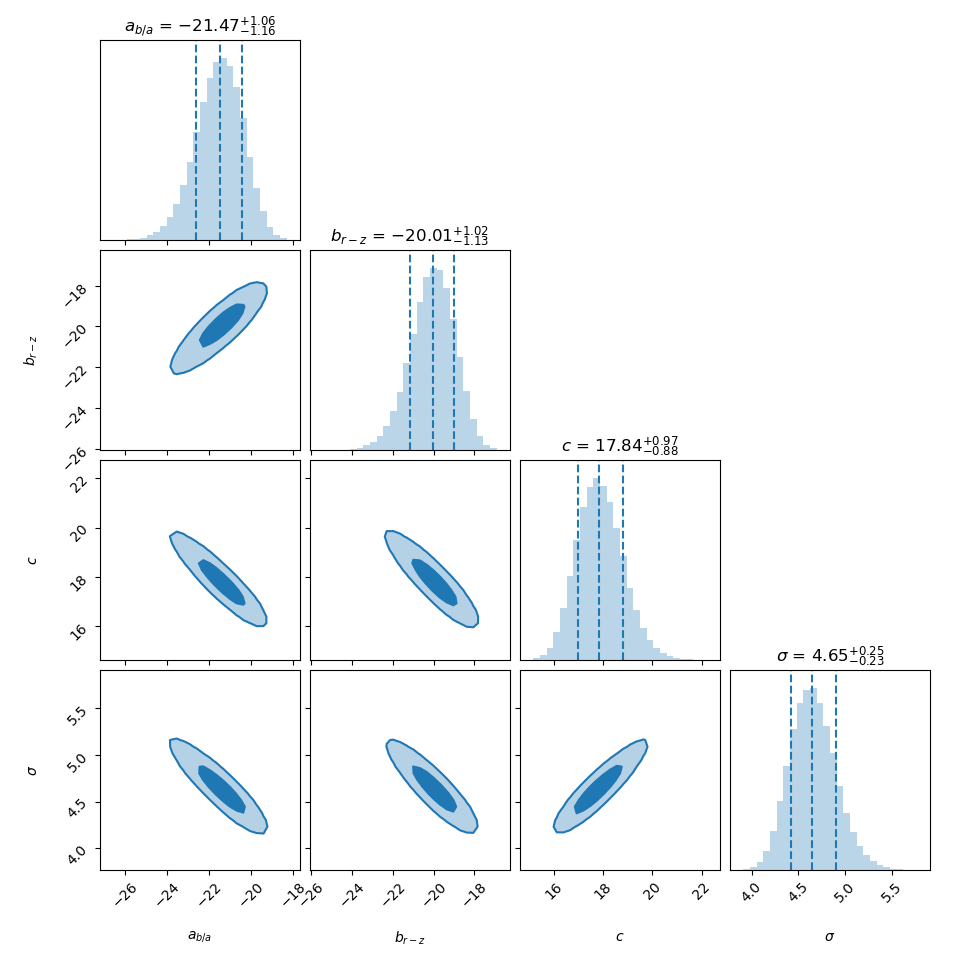

In [102]:
fig = corner.corner(mcmc_samples.T, 
                    bins=30, 
                    smooth=1, 
                    # range=[[-60, 0], [-0.3, -0.1], [0, 40], [1, 15]],
                    labels=['$a_{b/a}$', '$b_{r-z}$', '$c$', r'$\sigma$'], 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)), 
                    quantiles=[0.16, 0.5, 0.84], 
                    color='tab:blue', 
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3}, 
                    plot_datapoints=False,
                    fill_contours=True, 
                    show_titles=True);

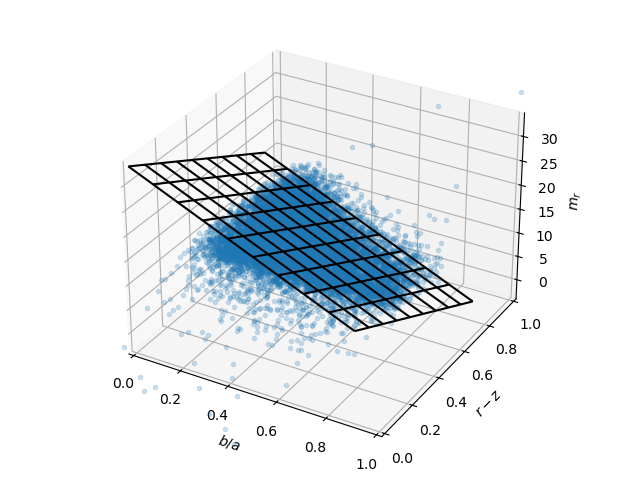

In [103]:
fig = plt.figure(tight_layout=True)
ax = fig.add_subplot(projection='3d')

ax.plot(gals['BA'], gals['R_MAG_SB26_CORR'] - gals['Z_MAG_SB26_CORR'], gals['R_MAG_SB26_CORR'], '.', alpha=0.2)
# ax.plot(np.ravel(ba_grid), np.ravel(R26_grid), np.ravel(mr_grid), '.', alpha=0.2)

ax.plot_wireframe(ba_grid, rz_grid, A_ba*ba_grid + B_rz*rz_grid + (C + mr_median), colors='k')

plt.xlim(0,1)
plt.ylim(0,1)

ax.set_xlabel('$b/a$')
ax.set_ylabel('$r-z$')
ax.set_zlabel('$m_r$');

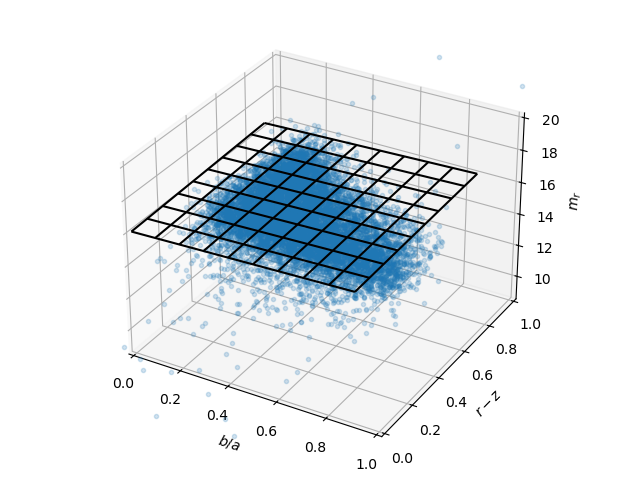

In [104]:
# Results from minimize
fig = plt.figure(tight_layout=True)
ax = fig.add_subplot(projection='3d')

ax.plot(gals['BA'], gals['R_MAG_SB26_CORR'] - gals['Z_MAG_SB26_CORR'], gals['R_MAG_SB26_CORR'], '.', alpha=0.2)
# ax.plot(np.ravel(ba_grid), np.ravel(R26_grid), np.ravel(mr_grid), '.', alpha=0.2)

ax.plot_wireframe(ba_grid, rz_grid, 0.44397033*ba_grid + 0.41396538*rz_grid + (0.02067235 + mr_median), colors='k')

plt.xlim(0,1)
plt.ylim(0,1)

ax.set_xlabel('$b/a$')
ax.set_ylabel('$r-z$')
ax.set_zlabel('$m_r$');

## Let's try fitting a line to ($m_r$, $b/a$)

We're going to let $x = b/a$ and $y = m_r$

In [18]:
ba_binwidth = 0.1
ba = np.arange(0.1,1,ba_binwidth)

In [19]:
N = len(gals['R_MAG_SB26_CORR'])
N_bins = len(ba)

In [20]:
mr_bins = np.nan*np.ones(len(ba))
cov_bins = np.nan*np.ones((2, 2, N_bins))

for i in range(N_bins):
    gals_subset_ba = gals[(gals['BA'] > ba[i]) & (gals['BA'] <= ba[i] + ba_binwidth)]
    if len(gals_subset_ba) > 0:
        mr_bins[i] = np.median(gals_subset_ba['R_MAG_SB26_CORR'])
        # cov_bins[:,:,i] = np.array([[0., 0.], [0., np.std(gals_subset_ba['R_MAG_SB26_CORR'])**2]])
        # cov_bins[:,:,i] = np.array([[0., 0.], [0., np.mean((gals_subset_ba['R_MAG_SB26_CORR'] - mr_bins[i])**2)/len(gals_subset_ba)]])
        cov_bins[:,:,i] = np.array([[0., 0.], [0., 1/len(gals_subset_ba)]])

In [21]:
# Shift the pivot point (y-intercept) to minimize the correlations between the fit coefficients
mr_median = np.median(gals['R_MAG_SB26_CORR'])
print(mr_median)

16.1215309809694


In [22]:
# Create the Hyperfit object
# hf = LinFit([gals['BA'], gals['R_MAG_SB26_CORR'] - mr_median], cov)
hf_bins = LinFit([ba, mr_bins - mr_median], cov_bins)

In [23]:
# Set bounds of coefficients
bounds = ((-100.0, 1.0), (-1.0, 10.0), (1.0e-5, 50.))

In [24]:
# Run MCMC to fit plane
# mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)
mcmc_samples, mcmc_lnlike = hf_bins.emcee(bounds, verbose=True)

     fun: -19.524677133211824
     jac: array([0.00937455, 0.00148432, 0.00151381])
 message: 'Optimization terminated successfully.'
    nfev: 2266
     nit: 49
 success: True
       x: array([0.17852278, 0.20184975, 0.06114861])


100%|██████████| 1000/1000 [00:00<00:00, 2408.13it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [31.00620297 31.54818196 32.32997112] / 1616.4985560942905


100%|██████████| 1000/1000 [00:00<00:00, 2477.02it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [32.96122934 30.46822686 41.12501522] / 2056.2507607647763


100%|██████████| 1000/1000 [00:00<00:00, 2436.99it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [34.58281863 31.08440551 40.43018045] / 2021.5090223352408


100%|██████████| 1000/1000 [00:00<00:00, 2376.23it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [36.95523448 31.4425866  40.60294396] / 2030.1471978534994


100%|██████████| 1000/1000 [00:00<00:00, 2374.64it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [40.69231304 37.35179006 39.48101   ] / 2034.6156519151502


100%|██████████| 1000/1000 [00:00<00:00, 2450.90it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.26892991 47.38484272 39.56491117] / 2369.2421359167593


100%|██████████| 1000/1000 [00:00<00:00, 2359.91it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.23177371 51.40248986 42.23339775] / 2570.1244928905317


100%|██████████| 1000/1000 [00:00<00:00, 2443.53it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [46.19332978 52.58107269 44.19573601] / 2629.05363436906


100%|██████████| 1000/1000 [00:00<00:00, 2409.29it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.56957103 49.59604404 48.71356305] / 2479.802202173781


100%|██████████| 1000/1000 [00:00<00:00, 2409.10it/s]

Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.58876027 50.76967288 49.65156385] / 2538.483643797326


In [25]:
# Calculate parameter values and covariance matrix
A_ba, B, sig = np.median(mcmc_samples, axis=1)
'''
cov_fit = np.cov(mcmc_samples)
A_ba_err = np.sqrt(cov_fit[0,0])
B_err = np.sqrt(cov_fit[1,1])
'''
A_ba_err = np.std(mcmc_samples[0][(-1.5 < mcmc_samples[0]) & (mcmc_samples[0] < 0)])
B_err = np.std(mcmc_samples[1][(0 < mcmc_samples[1]) & (mcmc_samples[1] < 1)])
'''
A_ba_err = np.quantile(mcmc_samples[0], [0.16, 0.5, 0.84])
B_err = np.quantile(mcmc_samples[1], [0.16, 0.5, 0.84])
'''
print(f'{A_ba:.2f} +/- {A_ba_err:.2f}')
print(f' {B:.2f} +/- {B_err:.2f}')

-0.90 +/- 0.17
 0.37 +/- 0.10


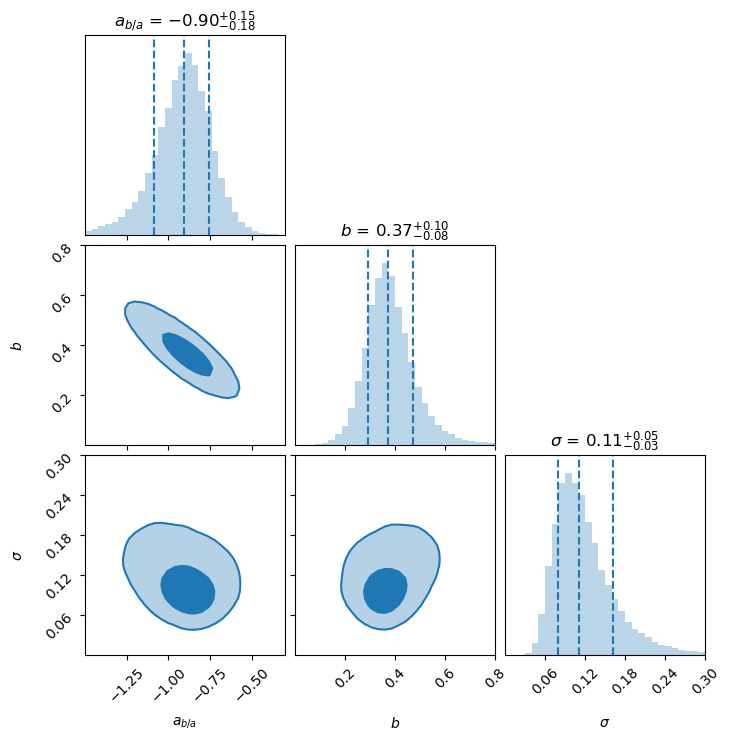

In [26]:
fig = corner.corner(mcmc_samples.T, 
                    bins=30, 
                    smooth=1, 
                    range=[[-1.5, -0.3], [0, 0.8], [0, 0.3]],
                    # range=[[-6, 6], [-3, 3], [0, 3]],
                    labels=['$a_{b/a}$', '$b$', r'$\sigma$'], 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)), 
                    quantiles=[0.16, 0.5, 0.84], 
                    color='tab:blue', 
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3}, 
                    plot_datapoints=False,
                    fill_contours=True, 
                    show_titles=True);

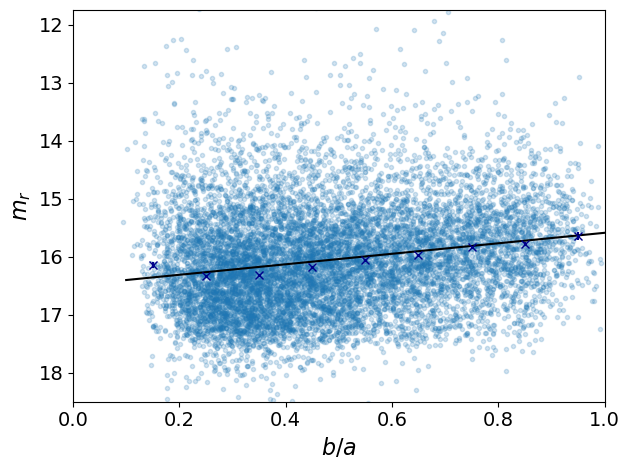

In [27]:
plt.figure(tight_layout=True)

plt.plot(gals['BA'], gals['R_MAG_SB26_CORR'], '.', alpha=0.2)
# plt.errorbar(ba, mr_bins, yerr=np.sqrt(cov_bins[1,1,:]), fmt='x', c='tab:blue')
plt.errorbar(ba + 0.05, mr_bins, yerr=np.sqrt(cov_bins[1,1,:]), fmt='x', c='darkblue')

plt.plot([0.1, 1], A_ba*np.array([0.1, 1]) + (B + mr_median), 'k')

plt.xlim([0, 1])
plt.ylim([18.5, 11.75])

plt.tick_params('both', which='major', labelsize=14)

plt.xlabel('$b/a$', fontsize=16)
plt.ylabel('$m_r$', fontsize=16);

# plt.savefig('../../Figures/Y1/iron_internalDustCorr_z0p1_20241211.png', dpi=150, facecolor='none');

### Save MCMC chains

In [28]:
temp_outfile = open('iron_internalDust_z0p1_mcmc.pickle', 'wb')
pickle.dump((mcmc_samples, mr_median), temp_outfile)
temp_outfile.close()

### Apply the correction and confirm that it removes the correlation

In [99]:
internalDust_corr, internalDust_corr_err = internal_dust(gals['BA'], 
                                                         [A_ba, B], 
                                                         [A_ba_err, B_err])

r_mag_sb26_corr = gals['R_MAG_SB26_CORR'] - internalDust_corr
r_mag_sb26_corr_err = np.sqrt(gals['R_MAG_SB26_ERR_CORR']**2 + internalDust_corr_err**2)

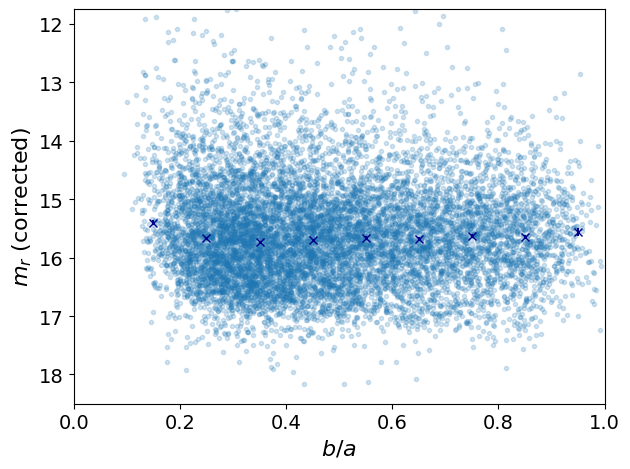

In [101]:
mr_bins_updated = np.nan*np.ones(len(ba))
cov_bins_updated = np.nan*np.ones((2, 2, N_bins))

for i in range(N_bins):
    ba_subset = (gals['BA'] > ba[i]) & (gals['BA'] <= ba[i]+0.1)
    if sum(ba_subset) > 0:
        mr_bins_updated[i] = np.median(r_mag_sb26_corr[ba_subset])
        cov_bins_updated[:,:,i] = np.array([[0., 0.], [0., 1/sum(ba_subset)]])


plt.figure(tight_layout=True)

plt.plot(gals['BA'], r_mag_sb26_corr, '.', alpha=0.2)
# plt.errorbar(ba, mr_bins, yerr=np.sqrt(cov_bins[1,1,:]), fmt='x', c='tab:blue')
plt.errorbar(ba + 0.05, mr_bins_updated, yerr=np.sqrt(cov_bins_updated[1,1,:]), fmt='x', c='darkblue')

plt.xlim([0, 1])
plt.ylim([18.5, 11.75])

plt.tick_params('both', which='major', labelsize=14)

plt.xlabel('$b/a$', fontsize=16)
plt.ylabel('$m_r$ (corrected)', fontsize=16);

## Let's also fit a line to ($m_z$, $b/a$) and ($m_g$, $b/a$)

So that we can see if this removes all residual correlations in the colors.

We're going to let $x = b/a$ and $y = m$

In [102]:
mg_bins = np.nan*np.ones(len(ba))
mz_bins = np.nan*np.ones(len(ba))

for i in range(N_bins):
    gals_subset_ba = gals[(gals['BA'] > ba[i]) & (gals['BA'] <= ba[i]+0.1)]
    if len(gals_subset_ba) > 0:
        mg_bins[i] = np.median(gals_subset_ba['G_MAG_SB26_CORR'])
        mz_bins[i] = np.median(gals_subset_ba['Z_MAG_SB26_CORR'])

In [103]:
# Shift the pivot point (y-intercept) to minimize the correlations between the fit coefficients
mz_median = np.median(gals['Z_MAG_SB26_CORR'])
mg_median = np.median(gals['G_MAG_SB26_CORR'])
print(mz_median, mg_median)

15.726890009336174 16.754790043243766


In [104]:
# Create the Hyperfit objects
zhf_bins = LinFit([ba, mz_bins - mz_median], cov_bins)
ghf_bins = LinFit([ba, mg_bins - mg_median], cov_bins)

In [105]:
# Run MCMC to fit lines
z_mcmc_samples, z_mcmc_lnlike = zhf_bins.emcee(bounds, verbose=True)
g_mcmc_samples, g_mcmc_lnlike = ghf_bins.emcee(bounds, verbose=True)

             message: Optimization terminated successfully.
             success: True
                 fun: -16.614559469172146
                   x: [ 1.016e-01  1.719e-01  8.801e-02]
                 nit: 52
                nfev: 2401
          population: [[ 1.016e-01  1.719e-01  8.801e-02]
                       [ 1.019e-01  1.721e-01  8.793e-02]
                       ...
                       [ 1.019e-01  1.721e-01  8.798e-02]
                       [ 1.015e-01  1.718e-01  8.818e-02]]
 population_energies: [-1.661e+01 -1.661e+01 ... -1.661e+01 -1.661e+01]
                 jac: [-5.609e-03 -2.040e-03 -7.367e-03]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6555.53it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [39.4489886  36.99251279 34.31567136] / 1972.4494298193824


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6615.81it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [57.65172716 49.1082082  37.34661139] / 2882.586357803888


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6786.70it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [75.47412439 72.66388622 50.70525272] / 3773.7062192733233


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6618.30it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 93.17697922 128.54733243  75.2440604 ] / 6427.366621398161


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6432.57it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [91.56375973 99.0511527  81.54005551] / 4952.5576349780995


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6580.17it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 95.70553574 103.31166788  68.72110049] / 5165.583393777135


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6719.89it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 99.65381362 127.46413354  87.01959715] / 6373.20667700864


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6607.95it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 99.12460775 118.73119832  72.19753157] / 5936.5599158203495


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6660.45it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [75.21734495 80.25314595 53.92571724] / 4012.657297402485


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6854.99it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [64.54289082 56.28579391 51.3477107 ] / 3227.144541213262


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6649.51it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [61.76497314 55.00482454 49.11666463] / 3088.2486572192497
             message: Optimization terminated successfully.
             success: True
                 fun: -20.049218141602935
                   x: [ 2.314e-01  2.066e-01  5.853e-02]
                 nit: 54
                nfev: 2491
          population: [[ 2.314e-01  2.066e-01  5.853e-02]
                       [ 2.313e-01  2.066e-01  5.854e-02]
                       ...
                       [ 2.313e-01  2.066e-01  5.855e-02]
                       [ 2.314e-01  2.066e-01  5.851e-02]]
 population_energies: [-2.005e+01 -2.005e+01 ... -2.005e+01 -2.005e+01]
                 jac: [ 4.190e-03  3.563e-04 -1.198e-03]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6621.46it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [24.9217886  30.42487264 27.93697278] / 1521.2436322033157


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6683.15it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [34.38896977 38.44202912 34.15873792] / 1922.1014561777943


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6810.41it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [38.37065992 37.78741973 33.76125295] / 1918.5329959438736


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6423.15it/s]

Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [36.55997467 38.76136332 33.89991096] / 1938.0681658485798


In [106]:
# Calculate parameter values and covariance matrix
Az_ba, Bz, sigz = np.median(z_mcmc_samples, axis=1)
Ag_ba, Bg, sigg = np.median(g_mcmc_samples, axis=1)

Az_ba_err = np.std(z_mcmc_samples[0][(-1.5 < z_mcmc_samples[0]) & (z_mcmc_samples[0] < 0)])
Bz_err = np.std(z_mcmc_samples[1][(0 < z_mcmc_samples[1]) & (z_mcmc_samples[1] < 1)])

Ag_ba_err = np.std(g_mcmc_samples[0][(-1.75 < g_mcmc_samples[0]) & (g_mcmc_samples[0] < -0.5)])
Bg_err = np.std(g_mcmc_samples[1][(0 < g_mcmc_samples[1]) & (g_mcmc_samples[1] < 1)])

print(f'{Az_ba:.2f} +/- {Az_ba_err:.2f}')
print(f' {Bz:.2f} +/- {Bz_err:.2f}')
print(f'{Ag_ba:.2f} +/- {Ag_ba_err:.2f}')
print(f' {Bg:.2f} +/- {Bg_err:.2f}')

-0.65 +/- 0.22
 0.27 +/- 0.13
-1.13 +/- 0.18
 0.47 +/- 0.11


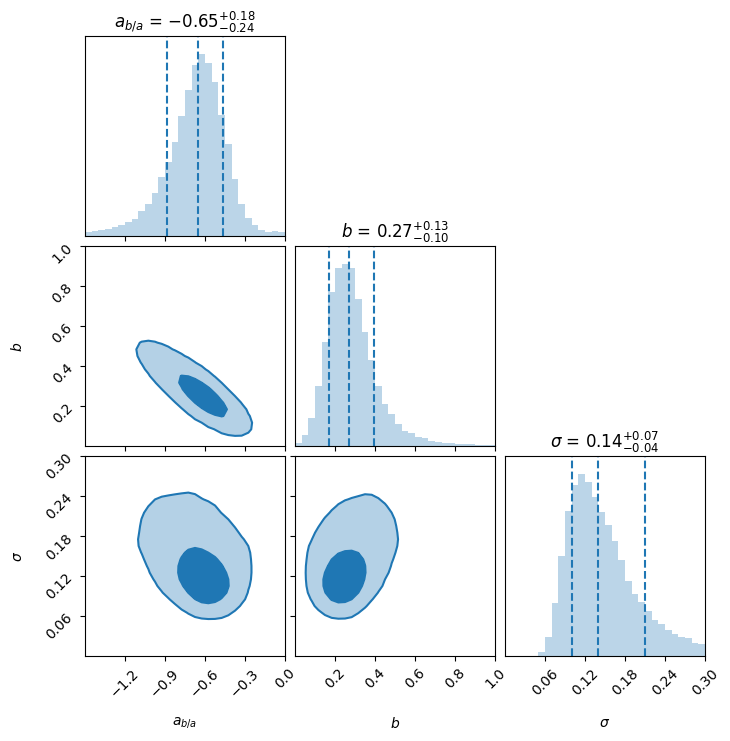

In [107]:
fig = corner.corner(z_mcmc_samples.T, 
                    bins=30, 
                    smooth=1, 
                    range=[[-1.5, 0], [0, 1], [0, 0.3]],
                    # range=[[-6, 6], [-3, 3], [0, 3]],
                    labels=['$a_{b/a}$', '$b$', r'$\sigma$'], 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)), 
                    quantiles=[0.16, 0.5, 0.84], 
                    color='tab:blue', 
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3}, 
                    plot_datapoints=False,
                    fill_contours=True, 
                    show_titles=True);

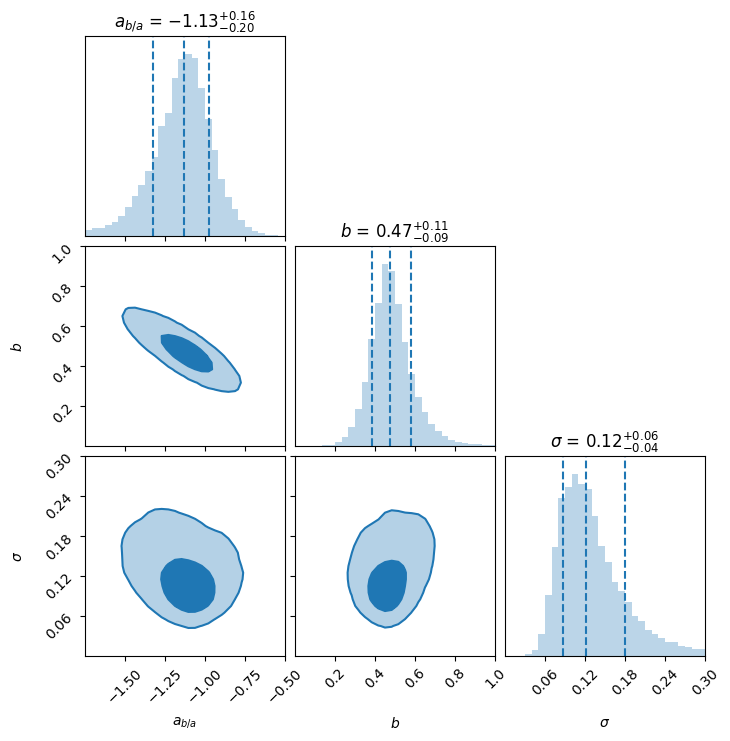

In [108]:
fig = corner.corner(g_mcmc_samples.T, 
                    bins=30, 
                    smooth=1, 
                    range=[[-1.75, -0.5], [0, 1], [0, 0.3]],
                    # range=[[-6, 6], [-3, 3], [0, 3]],
                    labels=['$a_{b/a}$', '$b$', r'$\sigma$'], 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)), 
                    quantiles=[0.16, 0.5, 0.84], 
                    color='tab:blue', 
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3}, 
                    plot_datapoints=False,
                    fill_contours=True, 
                    show_titles=True);

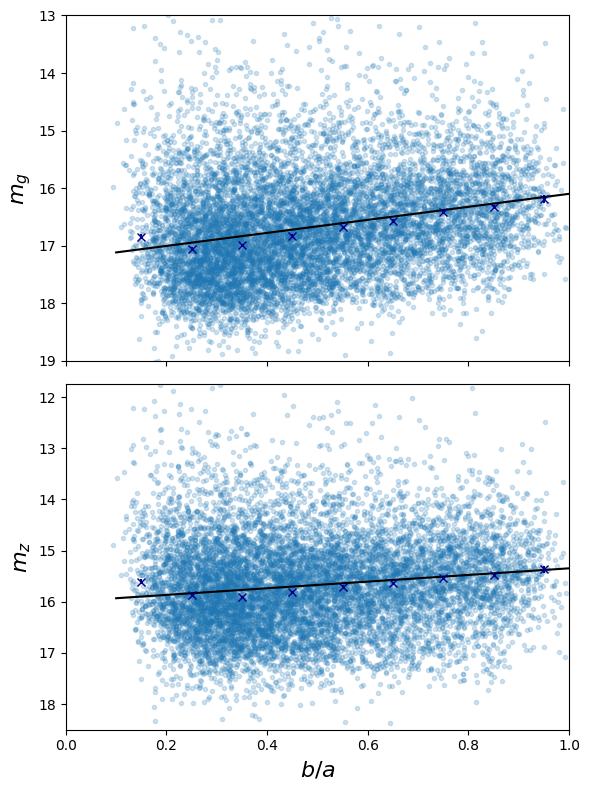

In [109]:
fig, axes = plt.subplots(2,1, figsize=(6,8), sharex=True, sharey=False, tight_layout=True)


ax = axes[0]
ax.plot(gals['BA'], gals['G_MAG_SB26_CORR'], '.', alpha=0.2)
ax.errorbar(ba + 0.05, mg_bins, yerr=np.sqrt(cov_bins[1,1,:]), fmt='x', c='darkblue')

ax.plot([0.1, 1], Ag_ba*np.array([0.1, 1]) + (Bg + mg_median), 'k')

ax.set_xlim([0, 1])
ax.set_ylim([19, 13])

# ax.set_tick_params('both', which='major', labelsize=14)

ax.set_ylabel('$m_g$', fontsize=16)


ax = axes[1]
ax.plot(gals['BA'], gals['Z_MAG_SB26_CORR'], '.', alpha=0.2)
ax.errorbar(ba + 0.05, mz_bins, yerr=np.sqrt(cov_bins[1,1,:]), fmt='x', c='darkblue')

ax.plot([0.1, 1], Az_ba*np.array([0.1, 1]) + (Bz + mz_median), 'k')

ax.set_ylim([18.5, 11.75])

# ax.set_tick_params('both', which='major', labelsize=14)

ax.set_xlabel('$b/a$', fontsize=16)
ax.set_ylabel('$m_z$', fontsize=16);

# plt.savefig('../../Figures/Y1/iron_internalDustCorr_z0p1_20241211.png', dpi=150, facecolor='none');

### Is our correlation between color and b/a gone?

In [113]:
internalDust_corr, internalDust_corr_err = internal_dust(gals['BA'], 
                                                         [Az_ba, Bz], 
                                                         [Az_ba_err, Bz_err])

z_mag_sb26_corr = gals['Z_MAG_SB26_CORR'] - internalDust_corr
z_mag_sb26_corr_err = np.sqrt(gals['Z_MAG_SB26_ERR_CORR']**2 + internalDust_corr_err**2)


internalDust_corr, internalDust_corr_err = internal_dust(gals['BA'], 
                                                         [Ag_ba, Bg], 
                                                         [Ag_ba_err, Bg_err])

g_mag_sb26_corr = gals['G_MAG_SB26_CORR'] - internalDust_corr
g_mag_sb26_corr_err = np.sqrt(gals['G_MAG_SB26_ERR_CORR']**2 + internalDust_corr_err**2)

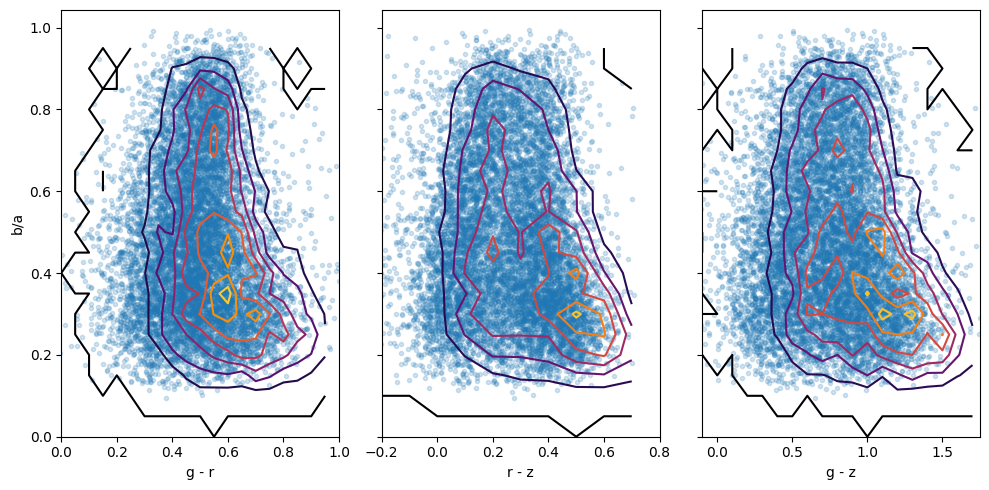

In [129]:
fig, ax = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(10,5))

counts, xbins, ybins = np.histogram2d(gals['G_MAG_SB26_CORR'] - gals['R_MAG_SB26_CORR'], 
                                      gals['BA'], 
                                      bins=[np.arange(0,1.05,0.05), np.arange(0,1.05,0.05)])
ax[0].plot(g_mag_sb26_corr - r_mag_sb26_corr, gals['BA'], '.', alpha=0.2)
ax[0].contour(xbins[:-1], ybins[:-1], counts.T, cmap='inferno')
ax[0].set_xlabel('g - r')
ax[0].set_ylabel('b/a')
ax[0].set_xlim([0, 1])

counts, xbins, ybins = np.histogram2d(gals['R_MAG_SB26_CORR'] - gals['Z_MAG_SB26_CORR'], 
                                      gals['BA'], 
                                      bins=[np.arange(-0.2,0.9,0.1), np.arange(0,1.05,0.05)])
ax[1].plot(r_mag_sb26_corr - z_mag_sb26_corr, gals['BA'], '.', alpha=0.2)
ax[1].contour(xbins[:-1], ybins[:-1], counts.T, cmap='inferno')
ax[1].set_xlabel('r - z')
ax[1].set_xlim([-0.2, 0.8])

counts, xbins, ybins = np.histogram2d(gals['G_MAG_SB26_CORR'] - gals['Z_MAG_SB26_CORR'], 
                                      gals['BA'], 
                                      bins=[np.arange(-0.1,1.85,0.1), np.arange(0,1.05,0.05)])
ax[2].plot(g_mag_sb26_corr - z_mag_sb26_corr, gals['BA'], '.', alpha=0.2)
ax[2].contour(xbins[:-1], ybins[:-1], counts.T, cmap='inferno')
ax[2].set_xlabel('g - z')
ax[2].set_xlim([-0.1, 1.75]);

### Save MCMC chains

In [110]:
temp_outfile = open('iron_internalDust_z0p1_mcmc.pickle', 'wb')
pickle.dump((mcmc_samples, mr_median, g_mcmc_samples, mg_median, z_mcmc_samples, mz_median), temp_outfile)
temp_outfile.close()

## Let's try fitting two lines: one to ($b/a$, $r-z$) and one to ($m_r$, $b/a$)

Where we scale the $b/a$ in the relation to $m_r$ by the relationship between $b/a$ and $r-z$

In [21]:
ba = np.arange(0.1,1,0.1)

In [22]:
N = len(gals['R_MAG_SB26_CORR'])
N_bins = len(ba)

In [23]:
rz_bins = np.nan*np.ones(len(ba))
cov_bins = np.nan*np.ones((2, 2, N_bins))

for i in range(N_bins):
    
    gals_subset_ba = gals[(gals['BA'] > i*0.1) & (gals['BA'] <= (i+1)*0.1)]
    
    if len(gals_subset_ba) > 0:
        
        rz_bins[i] = np.median(gals_subset_ba['R_MAG_SB26_CORR'] - gals_subset_ba['Z_MAG_SB26_CORR'])
        
        cov_bins[:,:,i] = np.array([[0., 0.], [0., 1/len(gals_subset_ba)]])

In [24]:
# Shift the pivot point (x-intercept) to minimize the correlations between the fit coefficients
rz_median = np.median(gals['R_MAG_SB26_CORR'] - gals['Z_MAG_SB26_CORR'])
print(rz_median)

0.3670404740273945


In [25]:
# Create the Hyperfit object for (b/a, r-z)
# hf = LinFit([gals['R_MAG_SB26_CORR'] - gals['Z_MAG_SB26_CORR'] - rz_median, gals['BA']], cov)
hf_bins1 = LinFit([rz_bins - rz_median, ba], cov_bins)

In [26]:
# Set bounds of coefficients
bounds1 = ((-1.0, 10.0), (-100.0, 1.0), (1.0e-5, 50.))

In [27]:
# Run MCMC to fit plane
# mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)
mcmc_samples1, mcmc_lnlike1 = hf_bins1.emcee(bounds1, verbose=True)

     fun: -27.991729284678396
     jac: array([-0.00101856,  0.00088924,  0.00056239])
 message: 'Optimization terminated successfully.'
    nfev: 3726
     nit: 81
 success: True
       x: array([0.20225244, 0.08158098, 0.01743188])


100%|██████████| 1000/1000 [00:00<00:00, 2134.57it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [36.39581902 35.96566028 29.06635676] / 1819.790951163586


100%|██████████| 1000/1000 [00:00<00:00, 2160.80it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [37.69946484 37.99842768 40.44152491] / 2022.076245412736


100%|██████████| 1000/1000 [00:00<00:00, 2151.01it/s]

Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [39.28183694 37.4471797  38.62686878] / 1964.0918471687396


In [30]:
# Calculate parameter values and covariance matrix
A_rz, B, sig = np.median(mcmc_samples1, axis=1)
'''
cov_fit = np.cov(mcmc_samples)
A_ba_err = np.sqrt(cov_fit[0,0])
B_err = np.sqrt(cov_fit[1,1])
'''
A_rz_err = np.std(mcmc_samples1[0][(-5 < mcmc_samples1[0]) & (mcmc_samples1[0] < 0)])
B_err = np.std(mcmc_samples1[1][(0 < mcmc_samples1[1]) & (mcmc_samples1[1] < 1)])
'''
A_ba_err = np.quantile(mcmc_samples[0], [0.16, 0.5, 0.84])
B_err = np.quantile(mcmc_samples[1], [0.16, 0.5, 0.84])
'''
print(f'{A_rz:.2f} +/- {A_rz_err:.2f}')
print(f' {B:.2f} +/- {B_err:.2f}')

-2.47 +/- 0.35
 0.58 +/- 0.03


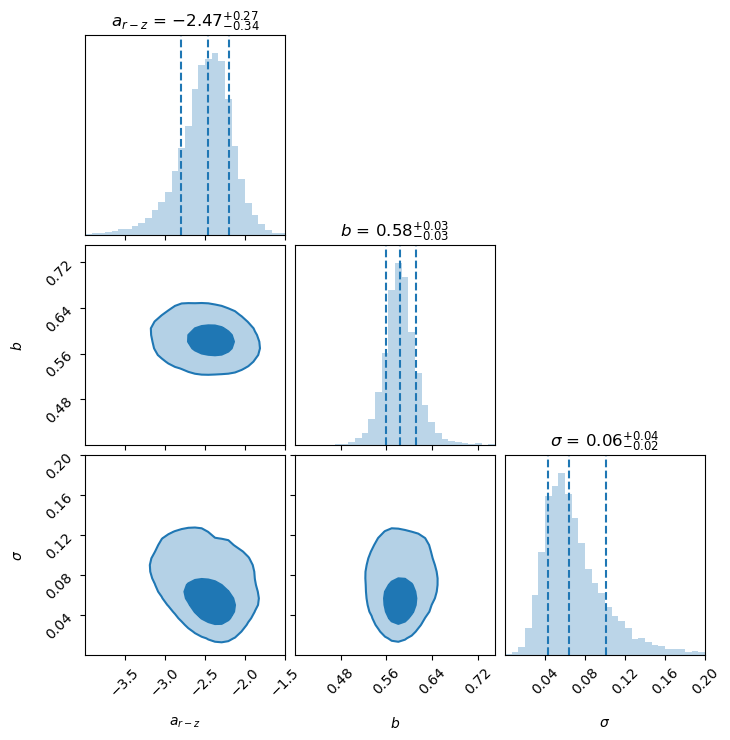

In [31]:
fig = corner.corner(mcmc_samples1.T, 
                    bins=30, 
                    smooth=1, 
                    range=[[-4, -1.5], [0.4, 0.75], [0, 0.2]],
                    # range=[[-6, 6], [-3, 3], [0, 3]],
                    labels=['$a_{r-z}$', '$b$', r'$\sigma$'], 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)), 
                    quantiles=[0.16, 0.5, 0.84], 
                    color='tab:blue', 
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3}, 
                    plot_datapoints=False,
                    fill_contours=True, 
                    show_titles=True);

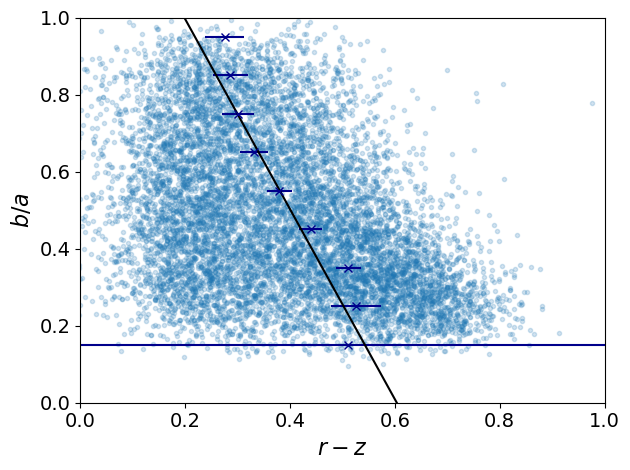

In [35]:
plt.figure(tight_layout=True)

plt.plot(gals['R_MAG_SB26_CORR'] - gals['Z_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
# plt.errorbar(ba, mr_bins, yerr=np.sqrt(cov_bins[1,1,:]), fmt='x', c='tab:blue')
plt.errorbar(rz_bins, ba + 0.05, xerr=np.sqrt(cov_bins[1,1,:]), fmt='x', c='darkblue')

plt.plot([0, 1], A_rz*(np.array([0, 1]) - rz_median) + B, 'k')

plt.ylim([0, 1])
plt.xlim([0, 1])

plt.tick_params('both', which='major', labelsize=14)

plt.xlabel('$r-z$', fontsize=16)
plt.ylabel('$b/a$', fontsize=16);

# plt.savefig('../../Figures/Y1/iron_internalDustCorr_z0p1_20241211.png', dpi=150, facecolor='none');

## Let's try fitting a line + exponential to ($m_r$, $b/a$)

\begin{equation}
  m_r = D_0 + D_1 (b/a) + D_2 e^{D_3 (b/a)}
\end{equation}

In [86]:
ba = np.arange(0.1,1,0.1)

In [87]:
N = len(gals['R_MAG_SB26_CORR'])
N_bins = len(ba)

In [88]:
mr_bins = np.nan*np.ones(N_bins)
mr_bin_err = np.nan*np.ones(N_bins)

for i in range(N_bins):
    
    gals_subset_ba = gals[(gals['BA'] > ba[i]) & (gals['BA'] <= ba[i]+0.1)]
    print(len(gals_subset_ba))
    
    if len(gals_subset_ba) > 0:
        
        mr_bins[i] = np.median(gals_subset_ba['R_MAG_SB26_CORR'])
        mr_bin_err[i] = np.mean((gals_subset_ba['R_MAG_SB26_CORR'] - mr_bins[i])**2)/len(gals_subset_ba)
        # mr_bin_err[i] = np.std(gals_subset_ba['R_MAG_SB26_CORR'])
        # mr_bin_err[i] = 1/np.sqrt(len(gals_subset_ba))

439
1719
2031
1723
1361
1125
937
718
209


In [78]:
def lin_exp_model(params, x):
    '''
    y = a0 + a1*x + a2*exp(a3*x)
    '''
    return params[0] + params[1]*x + params[2]*np.exp(params[3]*x)


def lin_ln_model(params, x):
    '''
    y = a0 + a1*x + a2*ln(a3*x)
    '''
    return params[0] + params[1]*x + params[2]*np.log(params[3]*x)


def logL_lin_exp(params, mr, mr_ivar, ba):
    '''
    Joint log-likelihood of the binned data


    Parameters
    ----------
    params : list or ndarray
        List of 4 parameters
    mr : ndarray
        Mean or median value of the apparent magnitude in each bin
    mr_ivar : ndarray
        Inverse variance of the binned magnitude value
    ba : ndarray
        b/a bin centers


    Returns
    -------
    logL : float
        Log likelihood of set (b/a, mr) given model parameters
    '''
    # lambda1 = lin_exp_model(params, ba)
    lambda1 = lin_ln_model(params, ba)
    lambda1[lambda1 <= 0] = np.finfo(dtype=np.float64).tiny

    return -0.5*np.sum(mr_ivar*(mr - lambda1)**2 - np.log(mr_ivar))


def nlogL_lin_exp(params, mr, mr_err, ba):
    mr_ivar = 1/mr_err**2
    return -logL_lin_exp(params, mr, mr_ivar, ba)

In [79]:
bounds = [(-50, 50), (-10, 10), (-100, 100), (-100, 100)]

p0 = [-1, 16.5, 1, 1]

bestfit = minimize(nlogL_lin_exp, 
                   p0, 
                   # method='B-BFGS-B', 
                   args=(mr_bins, mr_bin_err, ba), 
                   bounds=bounds)

bestfit

/var/folders/mg/fxh1s24d0n3_r0c39d3gs0g00000gq/T/ipykernel_28828/4137091963.py:45: RuntimeWarning: divide by zero encountered in divide
  mr_ivar = 1/mr_err**2
/var/folders/mg/fxh1s24d0n3_r0c39d3gs0g00000gq/T/ipykernel_28828/4137091963.py:41: RuntimeWarning: invalid value encountered in subtract
  return -0.5*np.sum(mr_ivar*(mr - lambda1)**2 - np.log(mr_ivar))


  message: ABNORMAL: 
  success: False
   status: 2
      fun: nan
        x: [-1.000e+00  1.000e+01  1.000e+00  1.000e+00]
      nit: 0
      jac: [       nan        nan        nan        nan]
     nfev: 105
     njev: 21
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

/var/folders/mg/fxh1s24d0n3_r0c39d3gs0g00000gq/T/ipykernel_28828/4137091963.py:12: RuntimeWarning: divide by zero encountered in log
  return params[0] + params[1]*x + params[2]*np.log(params[3]*x)


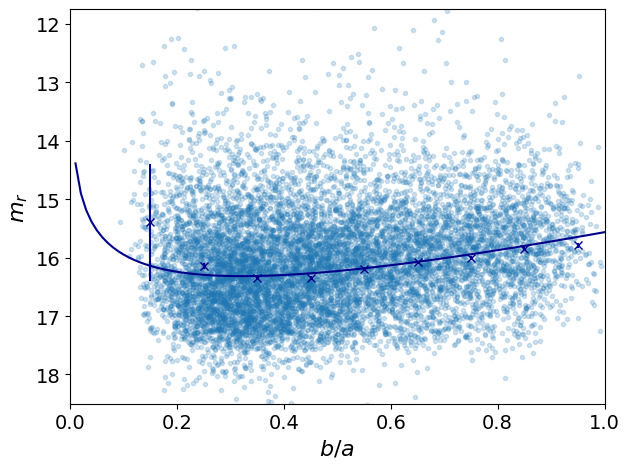

In [72]:
plt.figure(tight_layout=True)

plt.plot(gals['BA'], gals['R_MAG_SB26_CORR'], '.', alpha=0.2)
plt.errorbar(ba + 0.05, mr_bins, yerr=mr_bin_err, fmt='x', c='darkblue')

x = np.arange(0,1.01,0.01)
# plt.plot(x, lin_exp_model(bestfit.x, x), 'darkblue')
plt.plot(x, lin_ln_model(bestfit.x, x), 'darkblue')

plt.xlim([0, 1])
plt.ylim([18.5, 11.75])

plt.tick_params('both', which='major', labelsize=14)

plt.xlabel('$b/a$', fontsize=16)
plt.ylabel('$m_r$', fontsize=16);